# Data Analysis

In this tutorial, we will investigate the data used for training

## Imports

In [9]:
import sys
sys.path.append('../../')
import karman
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 15})


## Nowcasting Data

We first look at the ones without time series (used for the nowcasting models)

In [2]:
features_to_exclude_thermo=["all__dates_datetime__", "tudelft_thermo__satellite__", "tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]", "all__year__[y]", "NRLMSISE00__thermospheric_density__[kg/m**3]"]

min_date='2000-07-29 00:59:47'
max_date='2024-05-31 23:59:32'
karman_dataset=karman.KarmanDataset(thermo_path='../../data/merged_datasets/satellites_data_w_sw_2mln.csv',
                            min_date=pd.to_datetime(min_date),
                            max_date=pd.to_datetime(max_date),
                            features_to_exclude_thermo=features_to_exclude_thermo
                        )

Creating thermospheric density dataset
Removing from the data errors in mean absolute percentage error 200% or more in the density (between nrlmsise00 and ground truth)
loading it from file
Used features: Index(['tudelft_thermo__altitude__[m]', 'tudelft_thermo__latitude__[deg]',
       'celestrack__ap_average__',
       'space_environment_technologies__f107_obs__',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__s107_obs__',
       'space_environment_technologies__s107_average__',
       'space_environment_technologies__m107_obs__',
       'space_environment_technologies__m107_average__',
       'space_environment_technologies__y107_obs__',
       'space_environment_technologies__y107_average__', 'JB08__d_st_dt__[K]',
       'tudelft_thermo__longitude__[deg]_sin',
       'tudelft_thermo__longitude__[deg]_cos', 'all__day_of_year__[d]_sin',
       'all__day_of_year__[d]_cos', 'all__seconds_in_day__[s]_sin',
       'all__seconds_in_day__[s]

Inside the `karman_dataset.data_thermo`, there are now all the data, in particular, the original features are stored in `karman_dataset.data_thermo['data']`, whereas the normalized ones, are in `karman_dataset.data_thermo['data_matrix']`. The columns of the latter, for instance, match the columns of the `instantaneous_features` key in the `karman_dataset` class item:

In [4]:
karman_dataset[0]['instantaneous_features'].shape,karman_dataset.data_thermo['data_matrix'].shape

(torch.Size([18]), torch.Size([2036273, 18]))

How does a sample of the `karman_dataset` look like?

In [5]:
karman_dataset[0]

{'instantaneous_features': tensor([ 0.4965,  0.3186, -0.8007, -0.1492,  0.4357,  0.5696,  0.7742,  0.1767,
          0.5971,  0.7113,  0.7433, -0.4697,  0.0202,  0.9998, -0.4559, -0.8900,
          0.2705,  0.9627]),
 'nrlmsise00': tensor(1.0342e-12),
 'exponential_atmosphere': tensor(1.2454e-12),
 'target': tensor(0.0048),
 'ground_truth': tensor(1.2774e-12),
 'ap_average': tensor(27.),
 'geomagnetic_storm_G_class': 'G0',
 'altitude_bins': '450-500 km',
 'solar_activity_bins': 'F10.7: 150-200 (moderate-high)',
 'date': '2000-07-29 01:02:47.000000'}

Let's start with the first one: `instantaneous_features`.

This contains the normalized features that have been produced from the loaded thermospheric density dataset. This will also be used for training of the nowcasting model. If one wants less of these features, then the argument `features_to_exclude_thermo` can be used in the `KarmanDataset` class to exclude features. 


Note that by default, the features to be excluded from the originally loaded dataset are set to: `["all__dates_datetime__","tudelft_thermo__satellite__","tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]","all__year__[y]","NRLMSISE00__thermospheric_density__[kg/m**3]"]` but it can be changed to add more features to be excluded, in case necessary.


All right.. but how do I know which ones are my features in `instantaneous_features`, well one can do:

In [6]:
karman_dataset.column_names_instantaneous_features

Index(['tudelft_thermo__altitude__[m]', 'tudelft_thermo__latitude__[deg]',
       'celestrack__ap_average__',
       'space_environment_technologies__f107_obs__',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__s107_obs__',
       'space_environment_technologies__s107_average__',
       'space_environment_technologies__m107_obs__',
       'space_environment_technologies__m107_average__',
       'space_environment_technologies__y107_obs__',
       'space_environment_technologies__y107_average__', 'JB08__d_st_dt__[K]',
       'tudelft_thermo__longitude__[deg]_sin',
       'tudelft_thermo__longitude__[deg]_cos', 'all__day_of_year__[d]_sin',
       'all__day_of_year__[d]_cos', 'all__seconds_in_day__[s]_sin',
       'all__seconds_in_day__[s]_cos'],
      dtype='object')

As we see, some angle variables have been normalized with sin/cos, and hence a feature has become two (e.g. to properly describe the symmetric behavior in longitude)

The rest of the `karman_dataset` sample are:

* `nrlmsise00`: value in kg/m**3 of the NRLMSISE-00 thermospheric density for the same date(s) 
* `exponential_atmosphere`: value in kg/m**3 of the piecewise exponential thermospheric density for the same date
* `target`: min/max normalized value of the log10 of the thermospheric density, as derived from the POD data
* `ground_truth`: thermospheric density value in kg/m**3 as derived from the POD data
* `ap_average`: Ap average value for the corresponding date(s)
* `geomagnetic_storm_G_class`: classification (e.g. G0,G1,etc.) of the geomagnetic storm at the asked date(s)
* `altitude_bins`: altitude bin belonging to the queried date(s)
* `solar_activity_bins`: solar activity bin corresponding to the queried date(s) (in terms of F10.7 values)
* `date`: date(s) corresponding to the queried sample(s)


Most of these values might be redundant and retrievable somewhere, however, they make the life easier when doing things like benchmarking and comparison with other models.

All right... time to now plot the non-normalized data:

array([[<Axes: title={'center': 'all__dates_datetime__'}>,
        <Axes: title={'center': 'tudelft_thermo__altitude__[m]'}>,
        <Axes: title={'center': 'tudelft_thermo__longitude__[deg]'}>,
        <Axes: title={'center': 'tudelft_thermo__latitude__[deg]'}>,
        <Axes: title={'center': 'tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]'}>],
       [<Axes: title={'center': 'all__year__[y]'}>,
        <Axes: title={'center': 'all__day_of_year__[d]'}>,
        <Axes: title={'center': 'all__seconds_in_day__[s]'}>,
        <Axes: title={'center': 'celestrack__ap_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__f107_obs__'}>],
       [<Axes: title={'center': 'space_environment_technologies__f107_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__s107_obs__'}>,
        <Axes: title={'center': 'space_environment_technologies__s107_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__m107_o

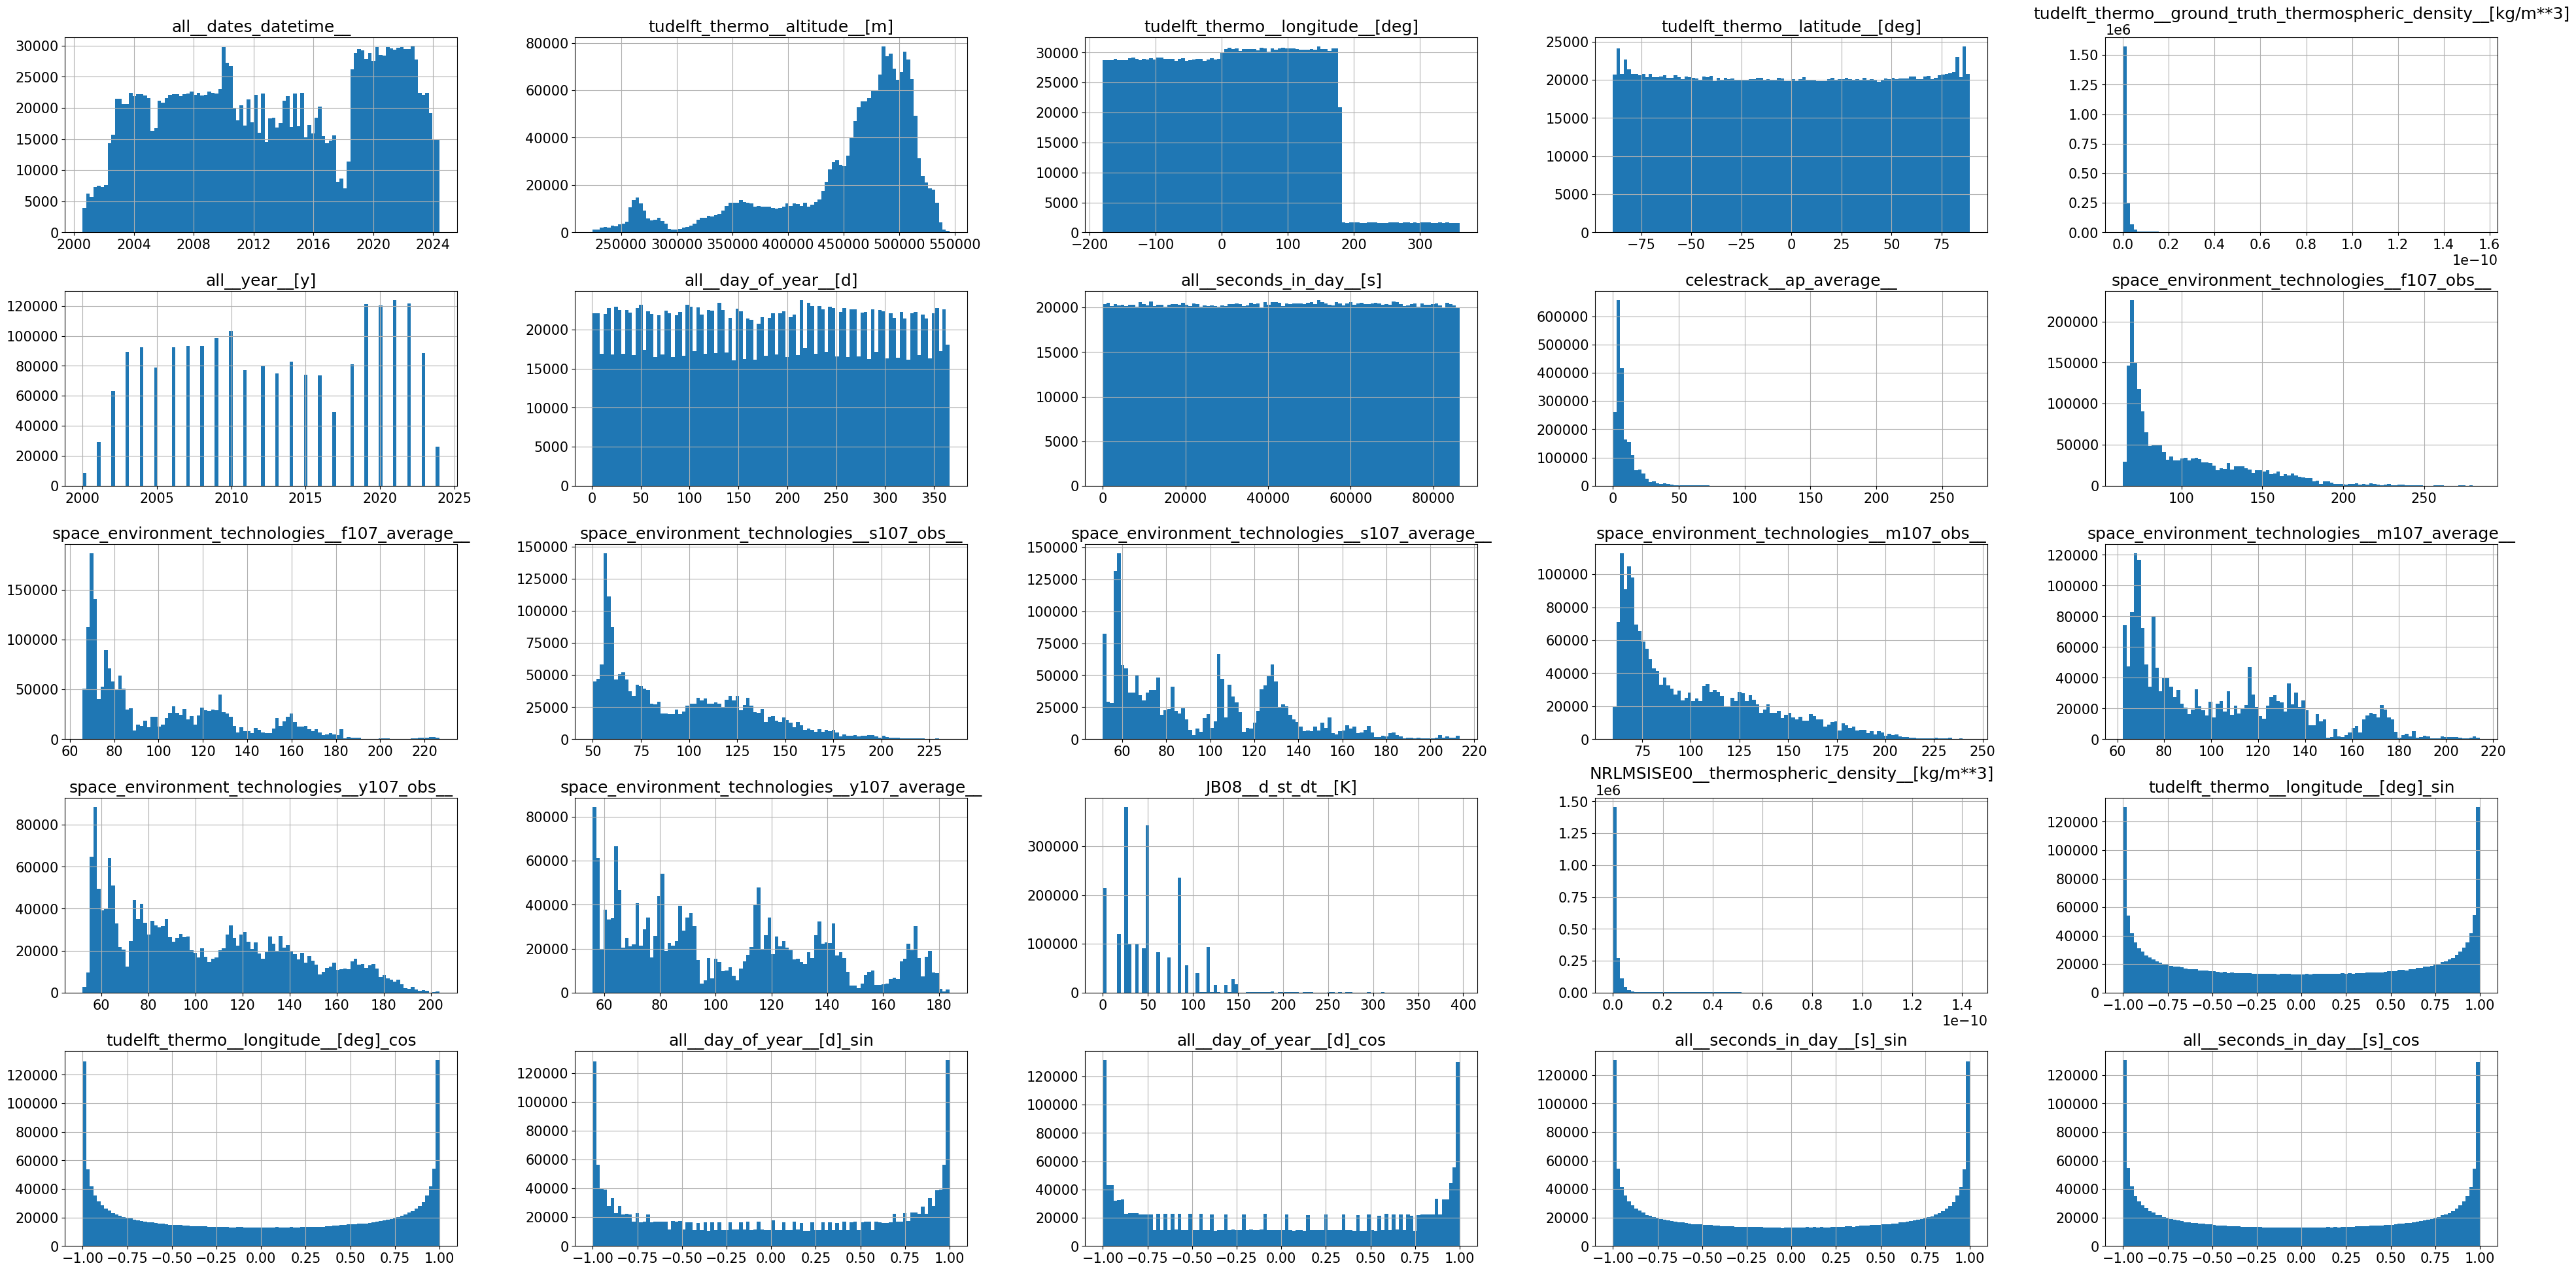

In [10]:
karman_dataset.data_thermo['data'].hist(figsize=(48,24),bins=100)

And the normalized ones:

array([[<Axes: title={'center': 'tudelft_thermo__altitude__[m]'}>,
        <Axes: title={'center': 'tudelft_thermo__latitude__[deg]'}>,
        <Axes: title={'center': 'celestrack__ap_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__f107_obs__'}>],
       [<Axes: title={'center': 'space_environment_technologies__f107_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__s107_obs__'}>,
        <Axes: title={'center': 'space_environment_technologies__s107_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__m107_obs__'}>],
       [<Axes: title={'center': 'space_environment_technologies__m107_average__'}>,
        <Axes: title={'center': 'space_environment_technologies__y107_obs__'}>,
        <Axes: title={'center': 'space_environment_technologies__y107_average__'}>,
        <Axes: title={'center': 'JB08__d_st_dt__[K]'}>],
       [<Axes: title={'center': 'tudelft_thermo__longitude__[deg]_sin'}>,
        <Axes

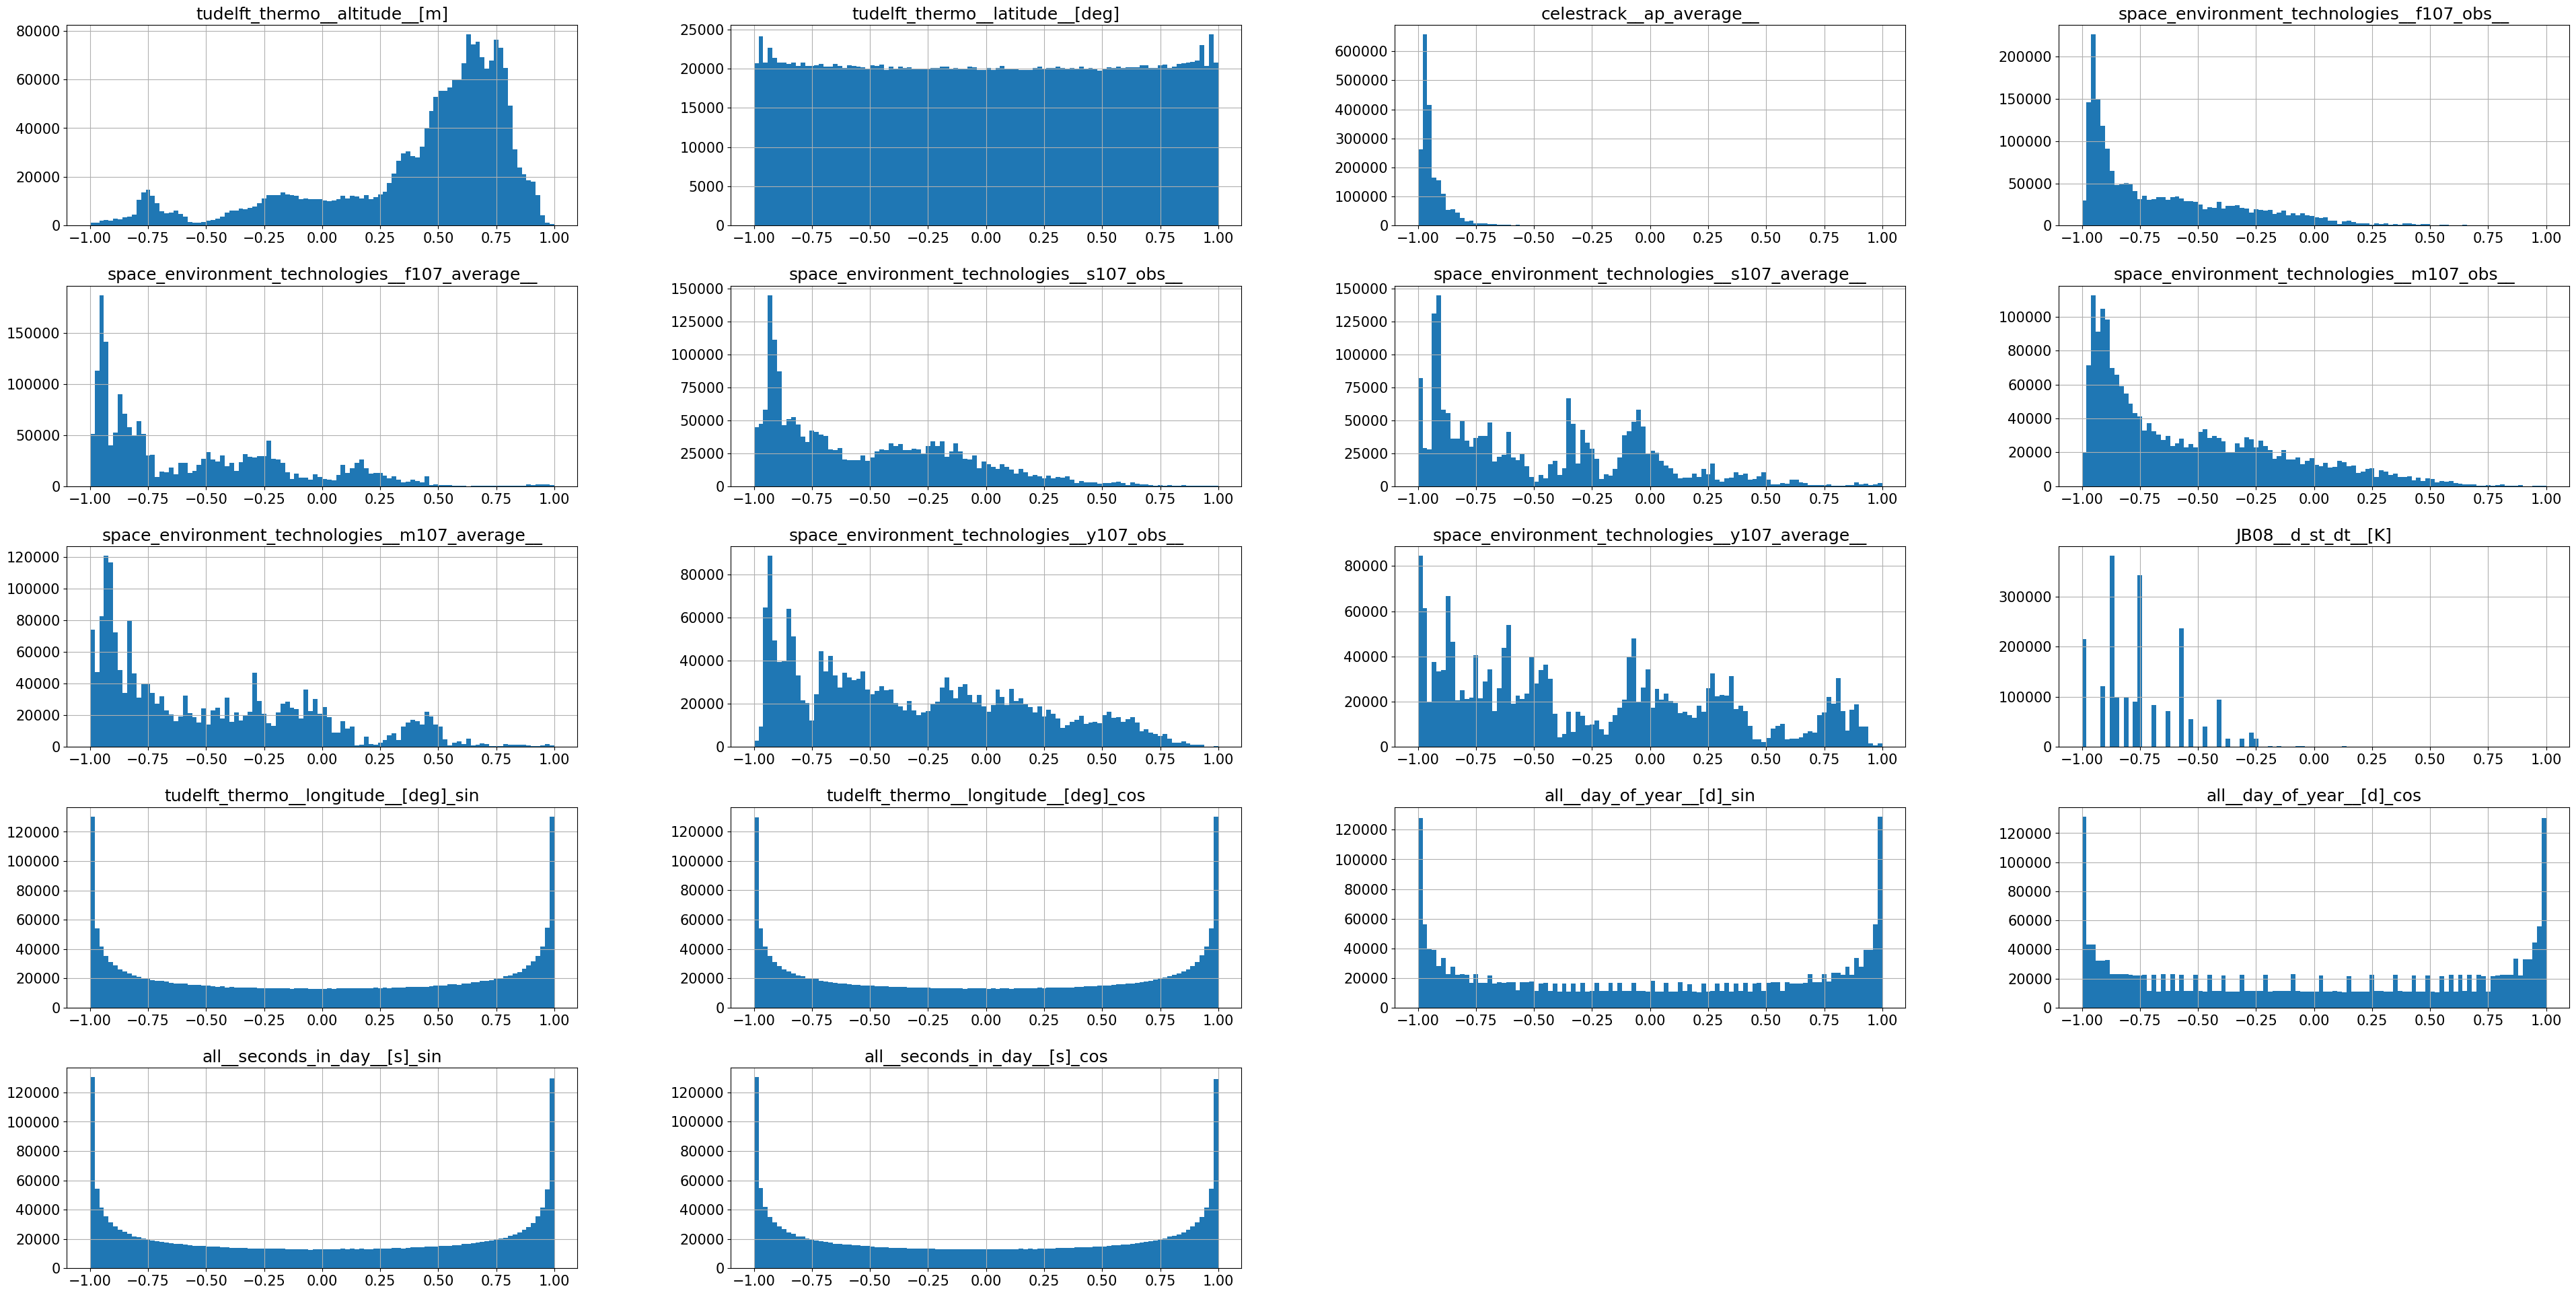

In [11]:
pd.DataFrame(data=karman_dataset.data_thermo['data_matrix'].numpy(), columns=list(karman_dataset.column_names_instantaneous_features)).hist(figsize=(48,24),bins=100)

## Forecasting Data

Let's now look at the data used for the forecasting models. In this case, we need to load extra data. Examples can include:

* OMNIWeb high-res data (either the indices data, or the magnetic field data, or the solar wind data)
* GOES data (one of the supported EUV irradiance wavelengths)
* SOHO EUV irradiance data
* NRLMSISE-00 time series data

For simplicity, we load now one of the OMNIWeb dataset, and show how it works (same can be done for the rest)

In [12]:
features_to_exclude_thermo=["all__dates_datetime__", "tudelft_thermo__satellite__", "tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]", "all__year__[y]", "NRLMSISE00__thermospheric_density__[kg/m**3]"]

min_date='2000-07-29 00:59:47'
max_date='2024-05-31 23:59:32'
karman_dataset=karman.KarmanDataset(thermo_path='../../data/merged_datasets/satellites_data_w_sw_2mln.csv',
                            min_date=pd.to_datetime(min_date),
                            max_date=pd.to_datetime(max_date),
                            features_to_exclude_thermo=features_to_exclude_thermo,
                            omni_magnetic_field_path='../../data/omniweb_data/merged_omni_magnetic_field.csv',
                            lag_minutes_omni=10000,
                            omni_resolution=100,
                            )

Loading Omni Magnetic Field.
Creating thermospheric density dataset
Removing from the data errors in mean absolute percentage error 200% or more in the density (between nrlmsise00 and ground truth)
loading it from file
Used features: Index(['tudelft_thermo__altitude__[m]', 'tudelft_thermo__latitude__[deg]',
       'celestrack__ap_average__',
       'space_environment_technologies__f107_obs__',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__s107_obs__',
       'space_environment_technologies__s107_average__',
       'space_environment_technologies__m107_obs__',
       'space_environment_technologies__m107_average__',
       'space_environment_technologies__y107_obs__',
       'space_environment_technologies__y107_average__', 'JB08__d_st_dt__[K]',
       'tudelft_thermo__longitude__[deg]_sin',
       'tudelft_thermo__longitude__[deg]_cos', 'all__day_of_year__[d]_sin',
       'all__day_of_year__[d]_cos', 'all__seconds_in_day__[s]_sin',
   

Now for the thermo data, everything is as before. However, we now have also the extra time series data, let's see how to access it.

Every time series data will be included as a key of the dictionary `karman_dataset.time_series_data`, as follows:

In [13]:
karman_dataset.time_series_data.keys()

dict_keys(['omni_magnetic_field'])

Let's see what are the keys of the `omni_magnetic_field` dictionary contained in the time series data:

In [14]:
karman_dataset.time_series_data['omni_magnetic_field'].keys()

dict_keys(['data', 'date_start', 'column_names', 'data_matrix', 'lag', 'scaler', 'resolution'])

These are meant to be all the useful information to work with this data. There are also information on the lag chosen (`lag`) and the resolution (`resolution`), both in minutes.

As for the nowcasting data, `karman_dataset.time_series_data['omni_magnetic_field']['data']` contains the non-normalized data, while `karman_dataset.time_series_data['omni_magnetic_field']['data_matrix']` contains the normalized ones. 

How was it normalized? Well `karman_dataset.time_series_data['omni_magnetic_field']['scaler']` contains the scipy scaler used for the purpose.


How does one know which are the features corresponding to the normalized data (i.e., `data_matrix`)? Well for that, we can do: `karman_dataset.time_series_data['omni_magnetic_field']['column_names']`, and those will be the features used. If the user wants to remove some of those features, the `KarmanDataset` argument `features_to_exclude_omni_magnetic_field` can be used for this purpose

Let's now look at the non-normalized data:

array([[<Axes: title={'center': 'omniweb__bx_gse__[nT]'}>,
        <Axes: title={'center': 'omniweb__by_gse__[nT]'}>],
       [<Axes: title={'center': 'omniweb__bz_gse__[nT]'}>, <Axes: >]],
      dtype=object)

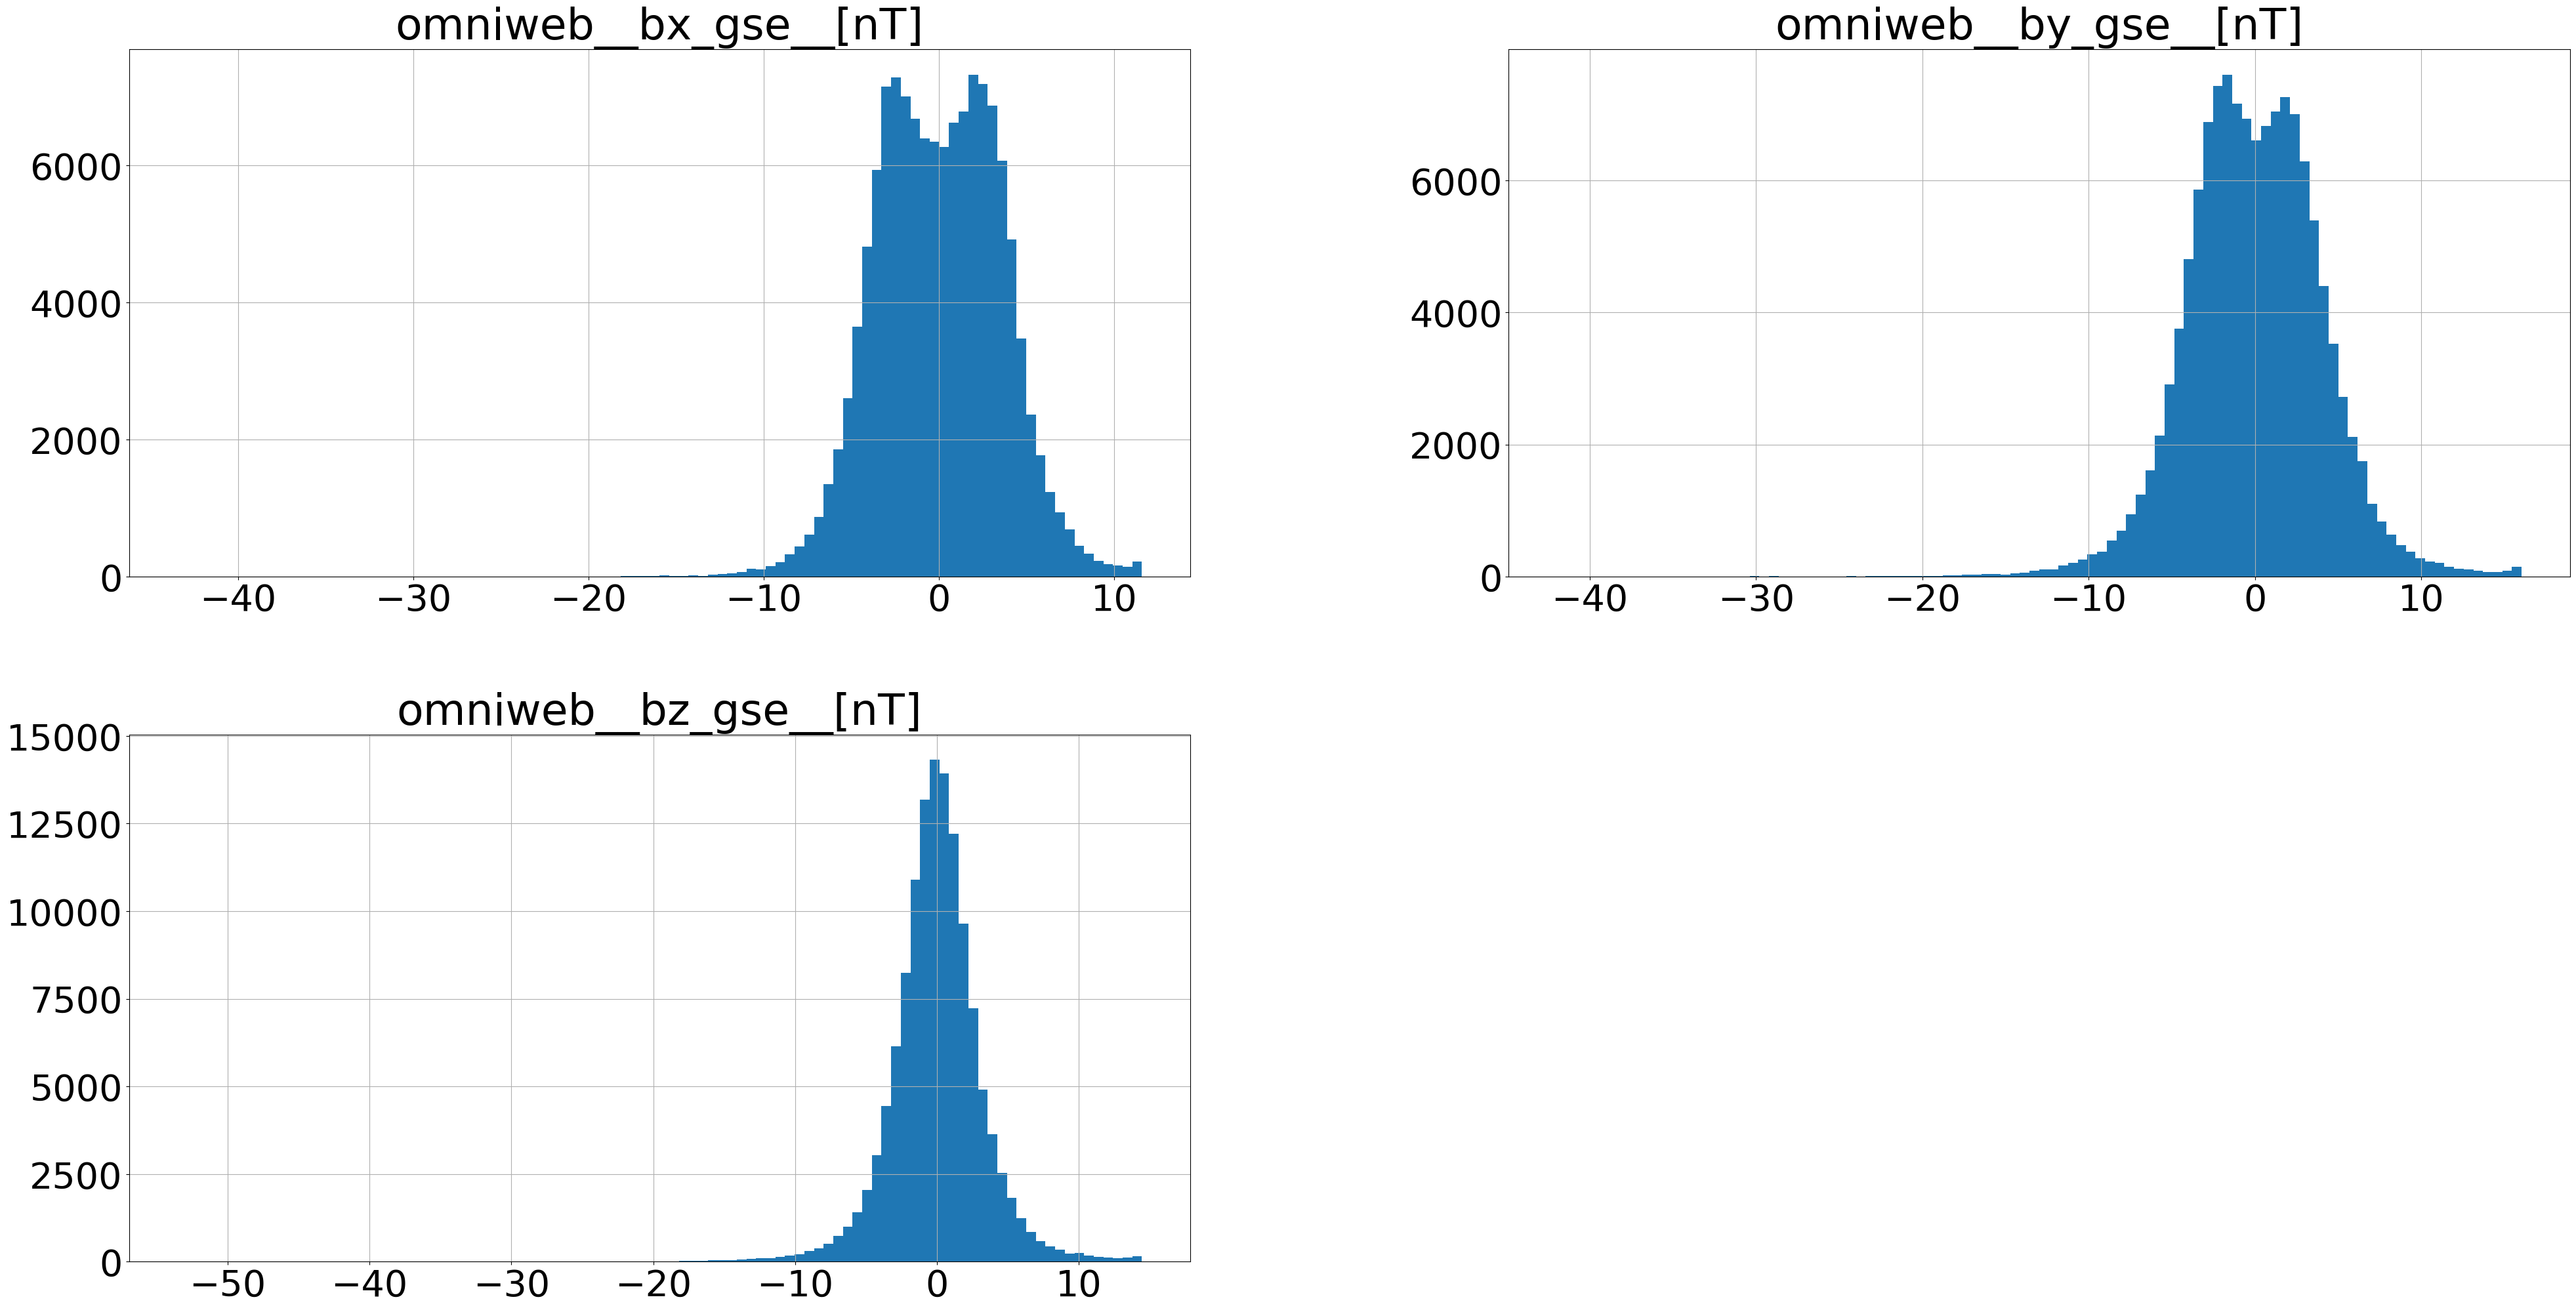

In [15]:
matplotlib.rcParams.update({'font.size': 40})
karman_dataset.time_series_data['omni_magnetic_field']['data'].hist(figsize=(48,24),bins=100)


And the normalized ones:

array([[<Axes: title={'center': 'omniweb__bx_gse__[nT]'}>,
        <Axes: title={'center': 'omniweb__by_gse__[nT]'}>],
       [<Axes: title={'center': 'omniweb__bz_gse__[nT]'}>, <Axes: >]],
      dtype=object)

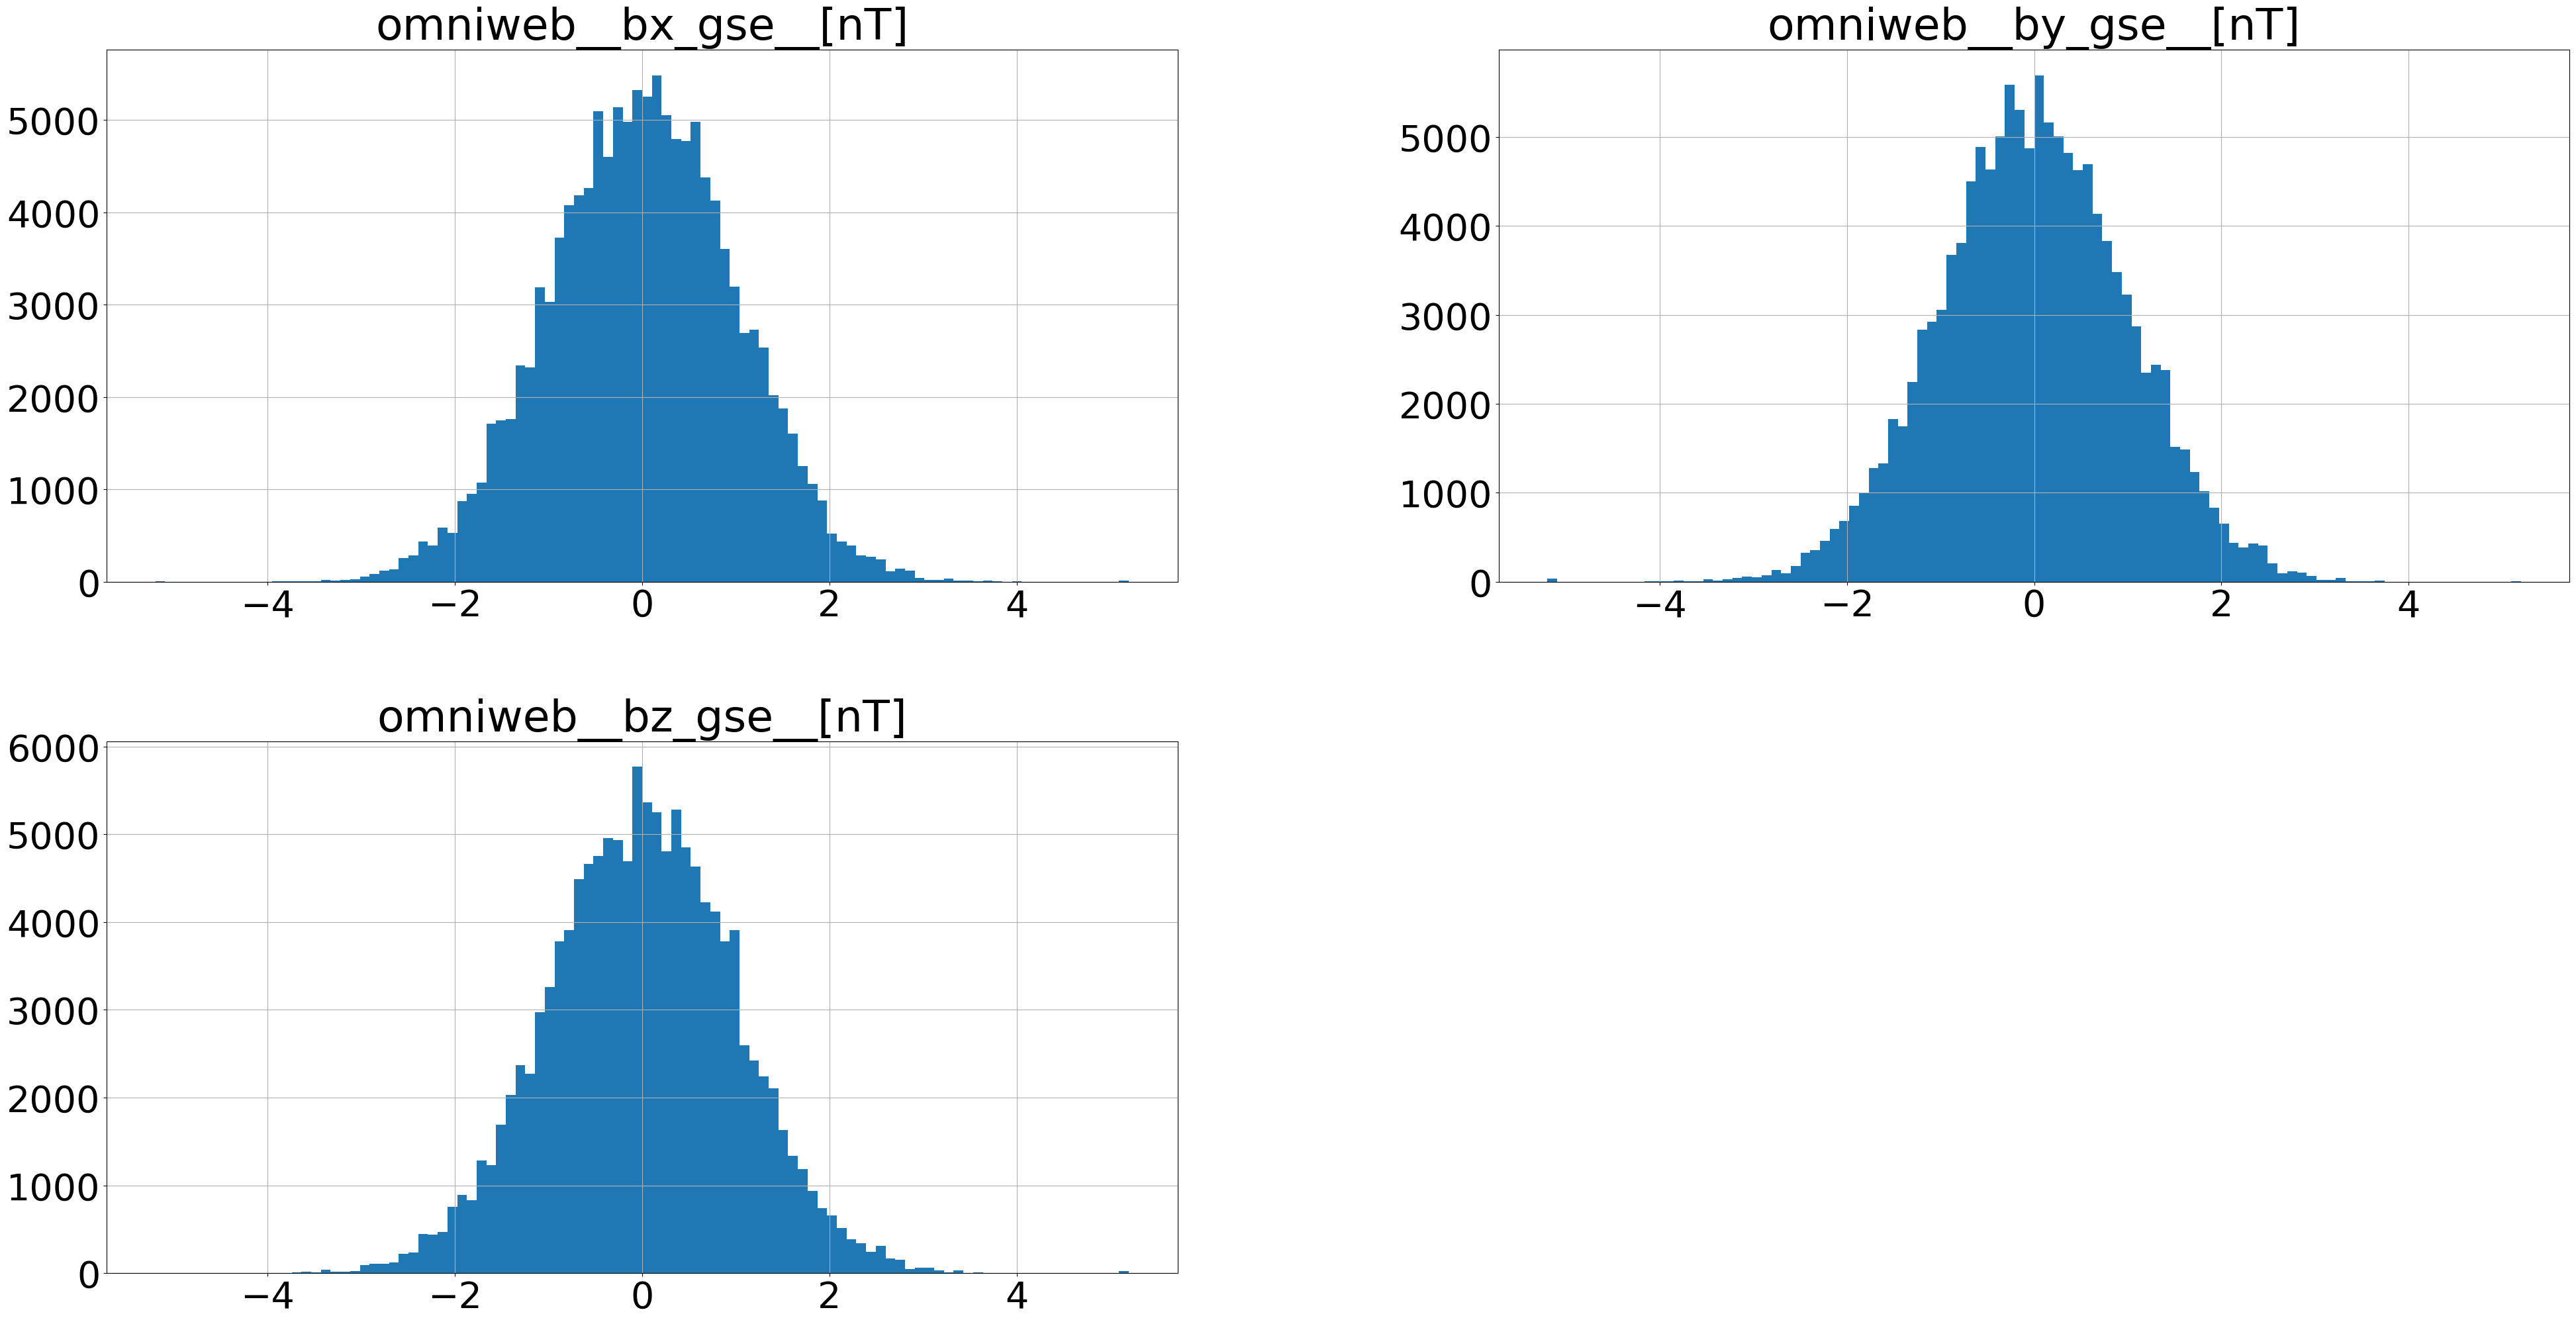

In [16]:
pd.DataFrame(data=karman_dataset.time_series_data['omni_magnetic_field']['data_matrix'].numpy(), columns=list(karman_dataset.time_series_data['omni_magnetic_field']['data'].columns)).hist(figsize=(48,24),bins=100)